# Solving coupled systems

## Main message
When you have a coupled or implicit system, you must use a solver to converge that system. Take time to recognize those systems within your models and identify the best way to solve them.

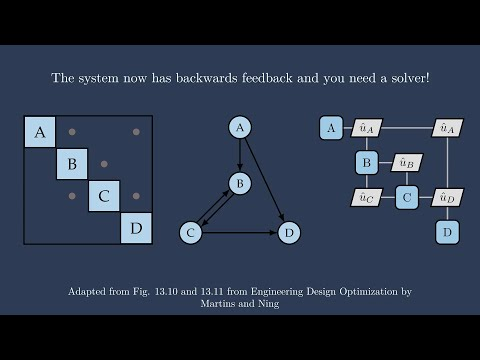

In [1]:
from IPython.display import YouTubeVideo; YouTubeVideo('wOOUacGFmVA', width=1024, height=576)

Video transcript available on YouTube and [here.](../VideoTranscripts/solving_coupled_systems.md)

## How to recognize when you need a solver
There are a few general cases when you need a solver for your system; 1) when you have any sort of feedback coupling between subsystems, and 2) when you have a while loop within an analysis, which essentially creates an implicit system. I'll now go into detail about each of these cases, focused on the general case of nonlinear systems of equations.

If you have a subsystem ("A") in your model that computes a quantity that is used by a subsystem ("B") downstream, that is known as "feed-forward coupling." If "A" runs before "B" and depends on data from "B", then you have "feedback coupling," or more commonly, just "coupling." **When you have feedback coupling in your model, you need to use a solver.**

Sometimes it might *look* like you have feedback coupling in your model, but you can reorder your subsystems to remove that coupling. That's the best case scenario! Then you can simply reorganize your system and avoid adding a solver unnecessarily.

Now, let's say you have some existing code that contains a `while` loop. This while loop has some sort of termination criteria, e.g. try to get the error below a certain value, or repeat until some mass value is close to another value. This while loop is considered an implicit system. It is converging some value through iterating. The same loop could be written as an implicit subsystem with a solver on it to resolve that implicitness. **When you have an implicit subsystem, you must use a solver.**

To be clear, coupling that requires a solver for your model can come from exclusively *explicit* subsystems if they pass data to upstream subsystems, or from the existence of just one *implicit* subsystem. A pairing of coupled explicit subsystems could be combined into a single implicit subsystem, so they are considered the same type of system at a rough mathematical level.

If you are developing a model from scratch, it should be relatively straightforward to determine if you need to solve a coupled system. You'll either have inter- or intra-disciplinary coupling, a while loop, or some sort of convergence loop.

If you're handed a model it might be more challenging to determine if there is feedback coupling (though OpenMDAO has helpful tools for that; more on that in a second). Given a model that someone else constructed, try to trace the execution order and data flow to see if there are any backwards coupling relationships. If no data is ever passed upstream of a given subsystem and there are no implicit relationships, it is a feed-forward system that does not require a nonlinear solver. Otherwise, you must use a solver to resolve the implicit relationships in the model.

Great news: if you have a model in OpenMDAO, there are a few foolproof ways to verify if you need a solver. The first and simplest is to use a command line tool to check your model and produce text output. The other is to create an N2 diagram and graphically example your model. I'll walk you through both of those options below.

First, let's use the `openmdao check` command line utility to check our system. Here we have a sample coupled system (the circuit example used in other lessons). In this case, we have no solvers set within the system. In a command line terminal (not Python) you can run `openmdao check sellar_example.py` and get the results shown below.

In [23]:
! openmdao check sellar_example.py

INFO: checking auto_ivc_warnings
INFO: checking comp_has_no_outputs
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking out_of_order
INFO: checking solvers
INFO: checking system
INFO: checking unserializable_options


The check utility warns you about any issues with the model. Those warnings are great hints for when your model is not behaving as expected. Here, it tells you that there is a cycle (backwards coupling) in the model, but there's no solver applied. Given this warning, you should absolutely add a solver to resolve the coupling.

Another option is to visually examine the N2 diagram. See [Using N2](TODO add link) for more info. Here is the terminal command to create an N2 diagram for a model along with an image of its output and the coupling highlighted.

Any squares below the diagonal along the model mean that the model has backwards coupling. If upstream components only pass data to downstream ones, there would be no squares of data below the main diagonoal.

In [24]:
! openmdao n2 sellar_example.py

![Sellar N2 diagram](sellar_n2.png)


## Solving a simple system by hand
You could solve relatively simple systems by hand or symbolically. Here's an example, something like from high school algebra:

$$9x^2 + y^2 = 9$$
$$y-3 =3x^2$$
Given some rearranging, you'd be able to analytically find the solution to this system of two equations with two unknowns. Here, it's relatively easy to reformulate the second equation then plug it into the first to obtain the value of x. Then you could find the value of y and be done with the system.

This is a pretty trivial example, but I wanted to include it to motivate the computational solvers we use in large-scale systems design. These were just two variables with two equations, but we're interested in systems with at least thousands of states described by at least thousands of equations. It would be quite untenable to solve these equations analytically, or even symbolically, let alone by hand. A lot of the equations we're interested in don't even have analytic solutions.

So, I'm simply showing what an extremely simple nonlinear system looks like. The states (here $x$ and $y$) can be solved for using a solver.

A linear system is a different but related type of system. Specialized solvers do a better job at solving these systems. See [[Nonlinear vs linear solvers]] for more information.

## A more complex system
Now let's investigate a more complex example. Here's an example of an engine model from [pyCycle](https://github.com/openmdao/pycycle). Intuitively, the flow properties through the engine are a collection of states that are governed by thermodynamic analysis of the system. For example, the mass flow of air entering the inlet must match the mass flow at the nozzle, accounting for fuel and combustion. This is an example of a state that must be converged using a solver on the coupled system.

This is an example case that *cannot* be solved using just one top level solver because the physical system and accompanying model are so complicated. It really helps in engine modeling to converge the states of subsystems before converging the states of the entire system. This involves nesting multiple solvers within the system, and [[Nested nonlinear solvers]] goes into more detail about this.

In this lesson, I don't want to belabor the fact that systems can be quite complex. Just know that the actual details about *how* best to solve coupled systems is more than an entire field of study. CFD and FEA solvers, any PDE framework, linear algebra algorithms, and neural networks all fall into this bucket. For this course we're focused on solving multidisciplinary nonlinear and linear systems that represent physical systems we're modeling.

## Notes specific for OpenMDAO
OpenMDAO is an amazing tool for using solvers in a multidisciplinary way. It helps you modularly set up your models and disciplines in a way that is solver independent yet allows for derivative-tracking throughout the system. Because of this, **I highly recommend using OpenMDAO's solver implementations instead of handcoding any solvers.** This means converting any while loops or similar convergence code snippets into using the OpenMDAO framework. Even if you're not using derivative information, using OpenMDAO opens up a lot of solver options, control, and tools that help you understand how best to converge the system. If you *do* need derivative information, using OpenMDAO's solvers is a must.

Other lectures will discuss more about specific implementations in OpenMDAO and show more example problems. Here, I just want to introduce the [OpenMDAO theory doc page on solvers](https://openmdao.org/newdocs/versions/latest/theory_manual/solver_api.html) which shows how the OpenMDAO solver implementations are categorized. This page also shows you how to create your own custom solver within OpenMDAO, but that is certainly a more advanced topic.